# Lab29 VGG with CIFAR10

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
import visdom

vis = visdom.Visdom()
vis.close(env="main")

Setting up a new session...


''

## Define Loss Tracker

In [5]:
def loss_tracker(loss_plot, loss_value, num):
    vis.line(X=num,Y=loss_value,win=loss_plot,update='append')

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True, num_workers=4)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


0it [00:00, ?it/s]

100%|█████████▉| 169771008/170498071 [00:26<00:00, 10968074.08it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


170500096it [00:40, 10968074.08it/s]                               

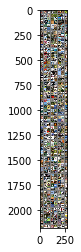

truck   dog horse truck


In [8]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()
    
dataiter = iter(trainloader)
images, labels = dataiter.next()
vis.images(images/2 + 0.5)

imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Make VGG16 using vgg.py

In [9]:
import torchvision.models.vgg as vgg

In [10]:
cfg = [32,32,'M',64,64,128,128,128,'M',256,256,256,512,512,512,'M']

In [12]:
class VGG(nn.Module):
    def __init__(self, features, num_classes=1000, init_weights=True):
        super(VGG,self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Linear(512 * 4 * 4, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()
            
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0),-1)
        x = self.classifier(x)
        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [13]:
vgg16 = VGG(vgg.make_layers(cfg), 10,True).to(device)

In [14]:
a = torch.Tensor(1,3,32,32).to(device)
out = vgg16(a)
print(out)

tensor([[ 3.2005e+35, -1.6975e+36, -1.1893e+36,  3.7216e+35, -1.1187e+36,
         -1.6774e+33,  8.5624e+35,  1.8786e+35,  1.3612e+36,  1.1897e+36]],
       device='cuda:0', grad_fn=<AddmmBackward>)


In [15]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(vgg16.parameters(), lr = 0.005, momentum=0.9)
lr_sche = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)

## Make Plot

In [16]:
loss_plt = vis.line(Y=torch.Tensor(1).zero_(),opts=dict(title='loss_tracker', legend =['loss'], showlegend=True))

## Training

In [17]:
print(len(trainloader))
epochs = 50

for epoch in range(epochs):
    running_loss = 0.0
    lr_sche.step()
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = vgg16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 30 == 29:
            loss_tracker(loss_plt, torch.Tensor([running_loss/30]), torch.Tensor([i + epoch * len(trainloader)]))
            print('[%d, %5d] loss: %.3f' % (epoch+1, i+1, running_loss /30))
            running_loss = 0.0
print('Finished Training')

98


/home/bigcloud/anaconda3/envs/hyunsoo/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


[1,    30] loss: 2.302
[1,    60] loss: 2.299
[1,    90] loss: 2.283
[2,    30] loss: 2.205
[2,    60] loss: 2.126
[2,    90] loss: 2.062
[3,    30] loss: 1.987
[3,    60] loss: 1.864
[3,    90] loss: 1.777
[4,    30] loss: 1.754
[4,    60] loss: 1.670
[4,    90] loss: 1.620
[5,    30] loss: 1.576
[5,    60] loss: 1.521
[5,    90] loss: 1.512
[6,    30] loss: 1.479
[6,    60] loss: 1.446
[6,    90] loss: 1.421
[7,    30] loss: 1.418
[7,    60] loss: 1.364
[7,    90] loss: 1.343
[8,    30] loss: 1.311
[8,    60] loss: 1.299
[8,    90] loss: 1.254
[9,    30] loss: 1.217
[9,    60] loss: 1.229
[9,    90] loss: 1.213
[10,    30] loss: 1.152
[10,    60] loss: 1.135
[10,    90] loss: 1.104
[11,    30] loss: 1.082
[11,    60] loss: 1.039
[11,    90] loss: 1.083
[12,    30] loss: 1.023
[12,    60] loss: 1.013
[12,    90] loss: 0.998
[13,    30] loss: 0.953
[13,    60] loss: 0.955
[13,    90] loss: 0.953
[14,    30] loss: 0.916
[14,    60] loss: 0.897
[14,    90] loss: 0.901
[15,    30] loss: 0

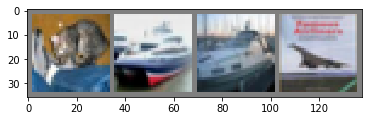

GroundTruth:    cat  ship  ship plane


In [18]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [19]:
outputs = vgg16(images.to(device))

In [20]:
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:    cat  ship  ship plane


In [21]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = vgg16(images)
        
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on the 10000 test images: %d %%' %(100*correct / total))

Accuracy of the network on the 10000 test images: 75 %
